# Notebook 2: Final Model Training

**Goal:** Train the model architecture using the best hyperparameters identified in Notebook 1 (`01_Hyperparameter_Optimization.ipynb`), employing early stopping to prevent overfitting and save the best performing model weights.

**Setup for this Run:**
*   **Model:** [Specify e.g., ResNet18]
*   **Unfreeze Strategy:** [Specify e.g., 'mid']
*   **Data Augmentation:** [Specify e.g., True/False]
*   **Best Hyperparameters:** Loaded from file generated by Notebook 1.

This notebook will:
1. Define the experimental setup parameters (matching Notebook 1).
2. Load the best hyperparameters identified during HPO.
3. Set up the data loaders, model, and optimizer using these best parameters.
4. Run the main training loop for a larger number of epochs.
5. Implement early stopping based on validation performance.
6. Save the `state_dict` of the model from the epoch with the best validation performance.
7. Save the full training and validation history (loss and accuracy per epoch).
8. Visualize the training curves.

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
import time
import os
import copy # To store best model state
from tqdm.notebook import tqdm # For progress bars
import matplotlib.pyplot as plt

# Import utility functions
import utils

# --- Define Setup for this Notebook Run ---
# MUST MATCH the setup used in Notebook 1 for which HPO was run

# Unique identifier for this experimental setup (used for loading/saving files)
SETUP_ID = 'resnet_mid_noaug' # <<< CHANGE THIS TO MATCH THE HPO RUN >>>

MODEL_NAME = 'resnet'          # 'resnet' or 'mobilenet'
UNFREEZE_STRATEGY = 'mid'     # 'head', 'mid', or 'deep'
AUGMENT_TRAIN = False          # True or False

# Final Training Parameters
MAX_EPOCHS = 50               # Maximum number of epochs to train
PATIENCE = 15                 # Early stopping patience (epochs to wait after last improvement)
BATCH_SIZE = 64               # Batch size for training

# --- Device Setup ---
if torch.backends.mps.is_available() and torch.backends.mps.is_built():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print(f"Using device: {device}")

# --- Unfreeze Strategy Mapping ---
resnet_unfreeze_map = {
    'head': ['fc.'],
    'mid':  ['fc.', 'layer4.'],
    'deep': ['fc.', 'layer4.', 'layer3.']
}
mobilenet_unfreeze_map = {
    'head': ['classifier.3.'],
    'mid':  ['classifier.3.', 'features.10.', 'features.11.', 'features.12.'],
    'deep': ['classifier.3.', 'features.8.', 'features.9.', 'features.10.', 'features.11.', 'features.12.']
}
if MODEL_NAME == 'resnet':
    layers_to_unfreeze = resnet_unfreeze_map[UNFREEZE_STRATEGY]
elif MODEL_NAME == 'mobilenet':
    layers_to_unfreeze = mobilenet_unfreeze_map[UNFREEZE_STRATEGY]

# --- Filenames ---
# Input file from Notebook 1
best_params_filename = f"best_params_{SETUP_ID}.json"
# Output files for this notebook
best_model_filename = f"best_model_{SETUP_ID}.pth"
train_history_filename = f"train_history_{SETUP_ID}.json"

print(f"Setup ID: {SETUP_ID}")
print(f"Model: {MODEL_NAME}, Unfreeze: {UNFREEZE_STRATEGY}, Augment: {AUGMENT_TRAIN}")
print(f"Max Epochs: {MAX_EPOCHS}, Patience: {PATIENCE}")
print(f"Layers to unfreeze contain: {layers_to_unfreeze}")

Using device: mps
Setup ID: resnet_mid_noaug
Model: resnet, Unfreeze: mid, Augment: False
Max Epochs: 50, Patience: 15
Layers to unfreeze contain: ['fc.', 'layer4.']


In [12]:
# Load the best hyperparameters identified in Notebook 1
print(f"Loading best hyperparameters from: {best_params_filename}")
# Add check if file exists? No error handling per request.
best_hyperparams = utils.load_json(best_params_filename)

print(f"Using hyperparameters: {best_hyperparams}")

# Extract specific hyperparameters for clarity
LR_HEAD = best_hyperparams['lr_head']
LR_BACKBONE = best_hyperparams['lr_backbone']
WEIGHT_DECAY = best_hyperparams['weight_decay']

Loading best hyperparameters from: best_params_resnet_mid_noaug.json
Using hyperparameters: {'lr_backbone': 0.0001, 'lr_head': 0.005, 'weight_decay': 0}


In [13]:
# 1. Load Model, adapt Head, apply Unfreeze Strategy
model = utils.get_model(MODEL_NAME)
model = utils.adapt_model_head(model, MODEL_NAME)
model = utils.apply_unfreeze_logic(model, layers_to_unfreeze)
model.to(device) # Move model to device *after* modifications
print(f"Model '{MODEL_NAME}' adapted and layers unfrozen according to '{UNFREEZE_STRATEGY}'.")

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total params: {total_params}, Trainable params: {trainable_params} ({100 * trainable_params / total_params:.2f}%)")

Model 'resnet' adapted and layers unfrozen according to 'mid'.
Total params: 11195493, Trainable params: 8412709 (75.14%)


In [14]:
# 2. Load Datasets and DataLoaders
train_dataset = utils.get_datasets(
    task = 'train',
    augment_train=AUGMENT_TRAIN
    )
train_loader = utils.get_dataloaders(task='train', dataset=train_dataset, batch_size=BATCH_SIZE)
print(f"DataLoader created. Train batches: {len(train_loader)}")

DataLoader created. Train batches: 58


In [15]:
# 4. Setup Optimizer using loaded best hyperparameters
optimizer = utils.get_optimizer(
    model=model,
    lr_head=LR_HEAD,
    lr_backbone=LR_BACKBONE,
    weight_decay=WEIGHT_DECAY
)
print("Optimizer created with loaded best hyperparameters.")

# 5. Define Loss Function
criterion = nn.CrossEntropyLoss()
print("Loss function (CrossEntropyLoss) defined.")

Optimizer created with loaded best hyperparameters.
Loss function (CrossEntropyLoss) defined.


In [16]:

def train_final_model(model, criterion, optimizer, train_loader, device, max_epochs, patience):
    """
    Trains the model on the provided training data.
    Implements early stopping based on training loss.
    Saves the model state dictionary with the lowest training loss in memory.
    Returns the best model state_dict and the training history.
    """
    history = {'train_loss': [], 'train_acc': []} # Only training metrics
    best_model_wts = None
    best_train_loss = float('inf') # Initialize best training loss to infinity
    epochs_no_improve = 0          # Counter for early stopping

    total_start_time = time.time()

    for epoch in range(max_epochs):
        epoch_start_time = time.time()
        print(f"\n--- Epoch {epoch+1}/{max_epochs} ---")

        # --- Training Phase ---
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        train_pbar = tqdm(train_loader, desc="Training", leave=False)

        for inputs, labels in train_pbar:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0) # Accumulate loss weighted by batch size
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()
            train_pbar.set_postfix(loss=loss.item())

        epoch_train_loss = running_loss / len(train_loader.dataset)
        epoch_train_acc = 100 * correct_train / total_train
        history['train_loss'].append(epoch_train_loss)
        history['train_acc'].append(epoch_train_acc)
        epoch_end_time = time.time()
        print(f"Train Loss: {epoch_train_loss:.4f} Acc: {epoch_train_acc:.2f}% | Time: {epoch_end_time - epoch_start_time:.2f}s")

        # --- Check for Improvement in Training Loss & Early Stopping ---
        # Note: Monitoring training loss for "improvement" (decrease) is unusual for early stopping.
        # Usually, one looks for validation loss to stop *increasing* or validation accuracy to stop *improving*.
        if epoch_train_loss < best_train_loss:
            print(f"Training loss improved ({best_train_loss:.4f} -> {epoch_train_loss:.4f}). Saving model...")
            best_train_loss = epoch_train_loss
            best_model_wts = copy.deepcopy(model.state_dict()) # Save the best weights
            epochs_no_improve = 0 # Reset counter
            # Save best model weights immediately to file (based on lowest training loss)
            torch.save(best_model_wts, best_model_filename) # best_model_filename defined in cell 1
            print(f"Best model (lowest training loss) weights saved to {best_model_filename}")
        else:
            epochs_no_improve += 1
            print(f"No improvement in training loss for {epochs_no_improve} epoch(s).")
            if epochs_no_improve >= patience:
                print(f"Early stopping triggered after {epoch+1} epochs based on training loss.")
                break # Exit training loop

    total_end_time = time.time()
    print(f"\nTraining Finished. Total time: {(total_end_time - total_start_time)/60:.2f} minutes")
    print(f"Lowest Training Loss Achieved: {best_train_loss:.4f}")

    # Load best model weights back into model before returning
    if best_model_wts:
        model.load_state_dict(best_model_wts)

    return model, history

In [17]:
print("Starting final training process...")
final_model, training_history = train_final_model(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    train_loader=train_loader,
    device=device,
    max_epochs=2,
    patience=PATIENCE
)

print("Final training complete.")

# Save the full training history (list of dictionaries)
utils.save_json(training_history, train_history_filename)
print(f"Training history saved to: {train_history_filename}")

Starting final training process...

--- Epoch 1/2 ---


Training:   0%|          | 0/58 [00:00<?, ?it/s]

Train Loss: 1.1051 Acc: 69.10% | Time: 35.56s
Training loss improved (inf -> 1.1051). Saving model...
Best model (lowest training loss) weights saved to best_model_resnet_mid_noaug.pth

--- Epoch 2/2 ---


Training:   0%|          | 0/58 [00:00<?, ?it/s]

Train Loss: 0.1719 Acc: 94.95% | Time: 34.60s
Training loss improved (1.1051 -> 0.1719). Saving model...
Best model (lowest training loss) weights saved to best_model_resnet_mid_noaug.pth

Training Finished. Total time: 1.17 minutes
Lowest Training Loss Achieved: 0.1719
Final training complete.
Training history saved to: train_history_resnet_mid_noaug.json


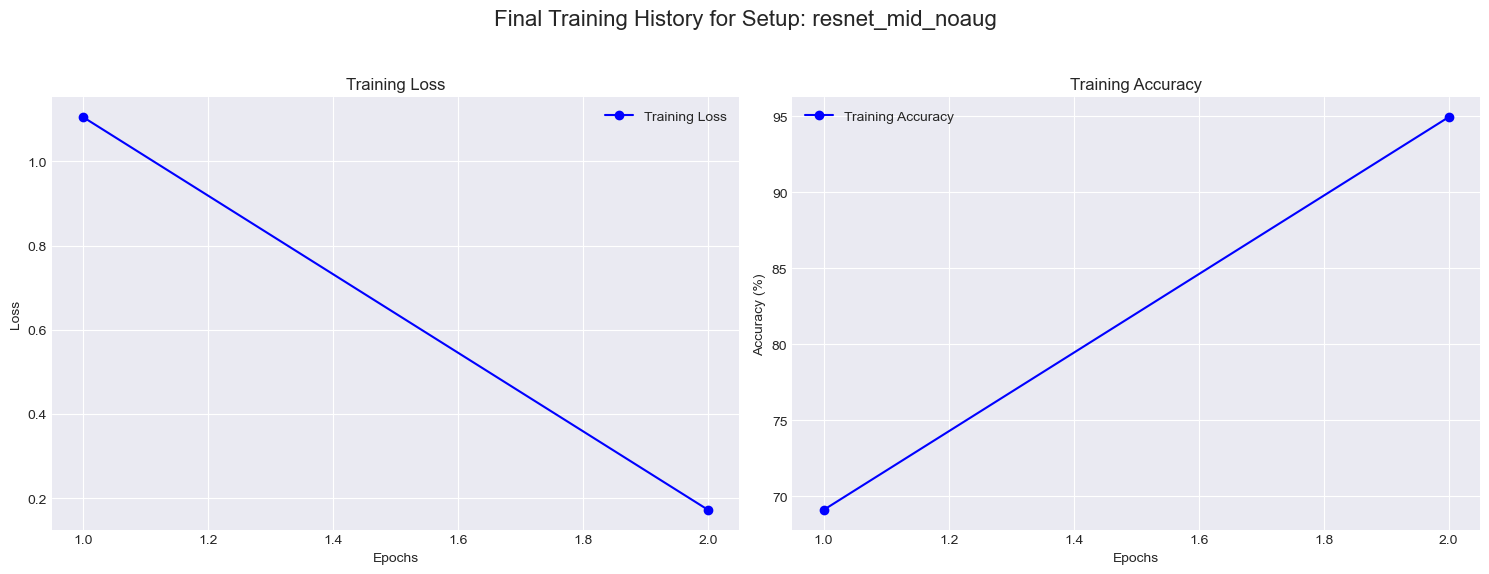

In [18]:
# (Code Cell 7 in 02_Final_Training.ipynb - Visualize Training History)
epochs_ran = len(training_history['train_loss'])
epochs = range(1, epochs_ran + 1)

plt.style.use('seaborn-v0_8-darkgrid')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Loss Plot
ax1.plot(epochs, training_history['train_loss'], 'bo-', label='Training Loss')
# No validation loss to plot
ax1.set_title('Training Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True)

# Accuracy Plot
ax2.plot(epochs, training_history['train_acc'], 'bo-', label='Training Accuracy')
# No validation accuracy to plot
ax2.set_title('Training Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy (%)')
ax2.legend()
ax2.grid(True)

fig.suptitle(f'Final Training History for Setup: {SETUP_ID}', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()